# Image Segementation and the Watershed Algorithm

In [3]:
import sys
sys.path.append('/Users/daniel/OAN/SID/')
import pandas

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [4]:
import sid_modules.helperFunctions as hf

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import re
import time

In [6]:
from scipy import ndimage
from tqdm import tqdm

In [7]:
df_images = hf.BigQueryHelper().loadImages()

Downloading: 100%|██████████| 5/5 [00:00<00:00, 22.42rows/s]


In [8]:
df_images

img_name          name  input_lat  input_lon  input_size  \
0        Monnon_5_19_500.png        Monnon   9.842513   3.178864         500   
1   Sansi Gando_5_19_500.png   Sansi Gando   9.947919   3.418565         500   
2  Besen Gourou_5_19_500.png  Besen Gourou   9.905893   3.350370         500   
3      Barkedje_5_19_500.png      Barkedje  10.025566   3.287887         500   
4        Boudal_5_19_500.png        Boudal   9.866730   3.172789         500   

   grid_size  zoom  lat_size  lon_size      lat_0     lon_0  m_per_px_lat  \
0          5    19      2285      2500   9.845532  3.175517      0.294187   
1          5    19      2285      2500   9.950937  3.415034      0.294093   
2          5    19      2285      2500   9.908911  3.346920      0.294131   
3          5    19      2285      2500  10.028584  3.284179      0.294023   
4          5    19      2285      2500   9.869749  3.169404      0.294166   

   m_per_px_lon  deg_per_m_lat  deg_per_m_lon  deg_per_px_lat  deg_per_px_lon  
0      0.298123       0.000008       0.000009        0.000002        0.000003  
1      0.298051       0.000008       0.000009        0.000002        0.000003  
2      0.298072       0.000008       0.000009        0.000002        0.000003  
3      0.298091       0.000008       0.000010        0.000002        0.000003  
4      0.298124       0.000008       0.000009        0.000002        0.000003

In [9]:
imreads = dict()
for vill in df_images['name'].unique():
    imreads[vill] = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

In [10]:
df = pd.read_gbq('SELECT * from output_data.poc_buildings_from_labeled')

In [11]:
df['houses'] = df['houses'].apply(eval)

In [2]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

## Our Task: Draw Contours Around the Coins

-----------------

## Common Coin Example

## Naive Approach

Let's try to simply use a threshold and then use findContours.

### Example Image

In [133]:
vill = df_images.iloc[0]['name']
vill

'Monnon'

In [134]:
image = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

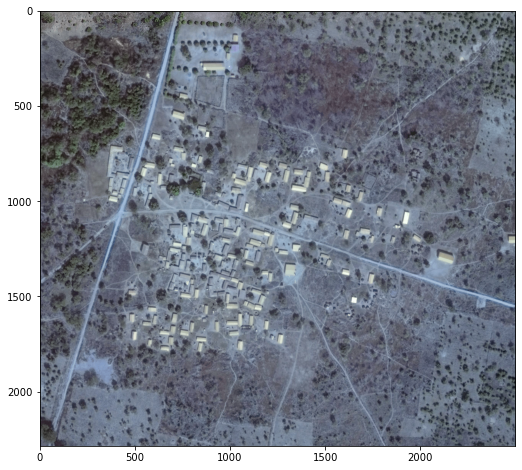

In [135]:
display(image)

### Apply Median Blurring

We have too much detail in this image, including light, the face edges on the coins, and too much detail in the background. Let's use Median Blur Filtering to blur the image a bit, which will be useful later on when we threshold.

In [136]:
sep_blur = cv2.medianBlur(image,25)

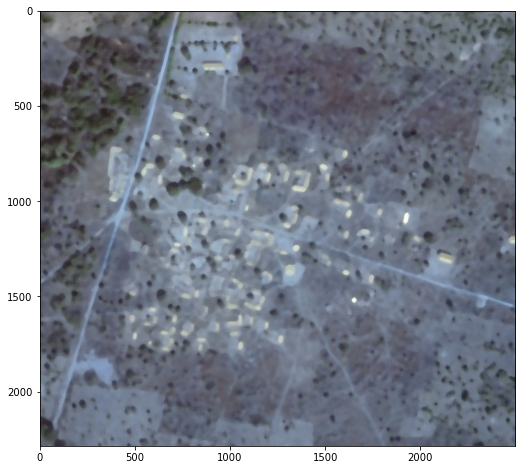

In [137]:
display(sep_blur)

In [138]:
gray_image = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)

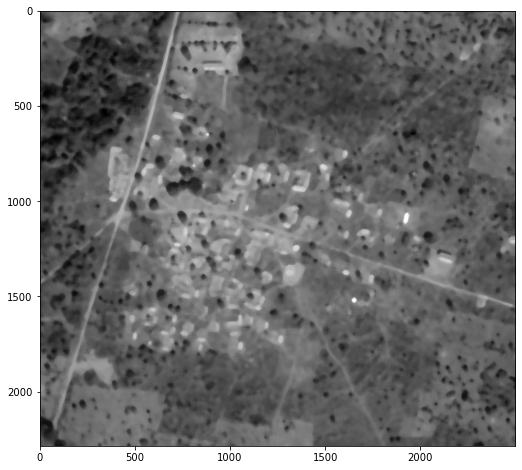

In [139]:
display(gray_image,cmap='gray')

## Binary Threshold

In [140]:
ret, sep_thresh = cv2.threshold(gray_image,160,255,cv2.THRESH_BINARY_INV)

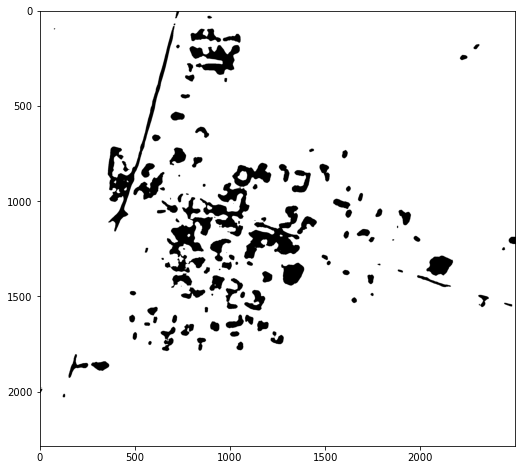

In [141]:
display(sep_thresh,cmap='gray')

## FindContours

In [142]:
contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [143]:
# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(image, contours, i, (255, 0, 0), 10)

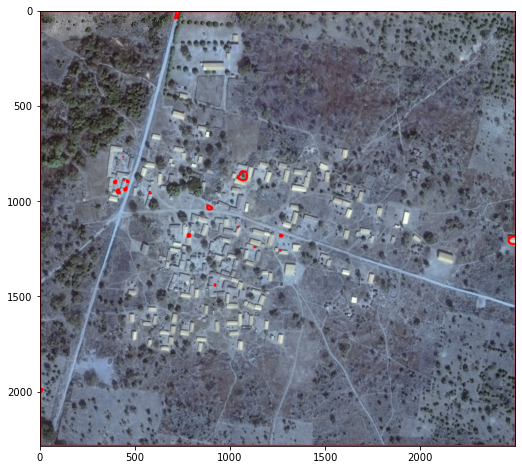

In [144]:
display(image)

# Watershed Algorithm

-----------

Let's now try the watershed algorithm apporach to draw contours around the pennies. Also make sure to watch the video to understand what the function calls are doing here.

## Using the WaterShed Algorithm

#### Step 1: Read Image

In [145]:
img = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

#### Step 2: Apply Blur

In [146]:
img = cv2.medianBlur(img,35)

#### Step 3: Convert to Grayscale

In [147]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### Step 4: Apply Threshold (Inverse Binary with OTSU as well)

In [148]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

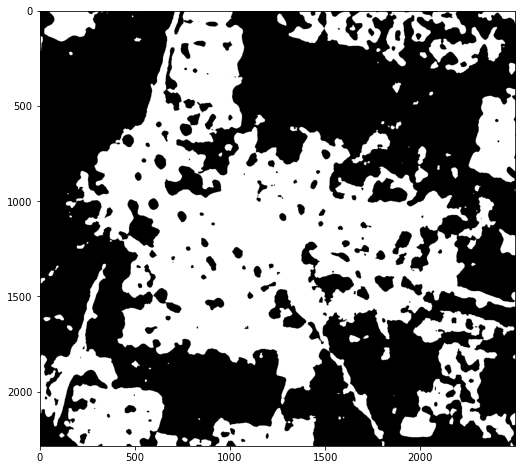

In [149]:
display(thresh,cmap='gray')

### Optional Step 5: Noise Removal

In [150]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

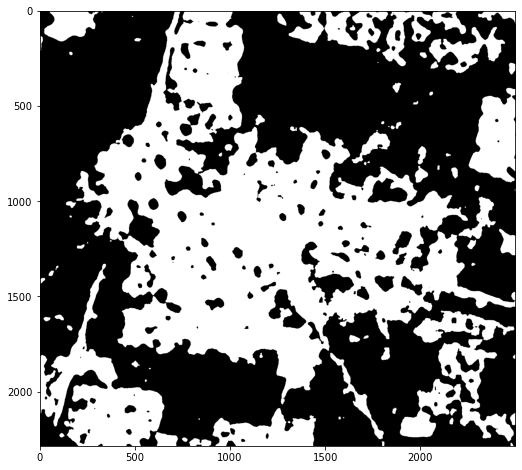

In [151]:
display(opening,cmap='gray')

#### Step 6: Grab Background that you are sure of

In [152]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

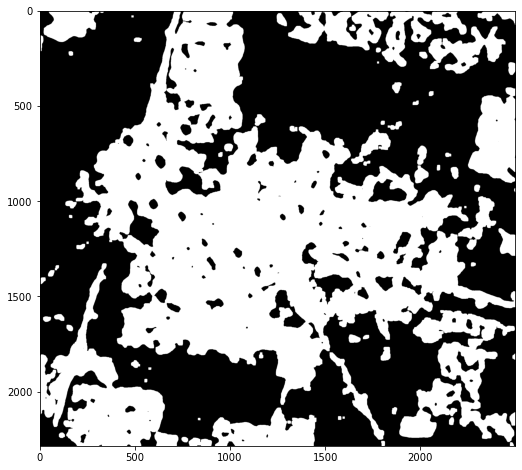

In [153]:
display(sure_bg,cmap='gray')

#### Step 7: Find Sure Foreground

In [154]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

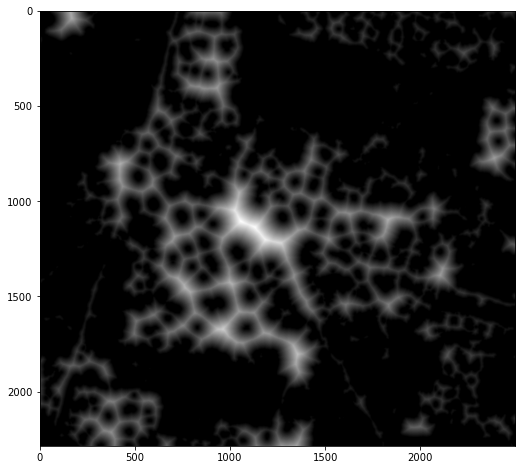

In [155]:
display(dist_transform,cmap='gray')

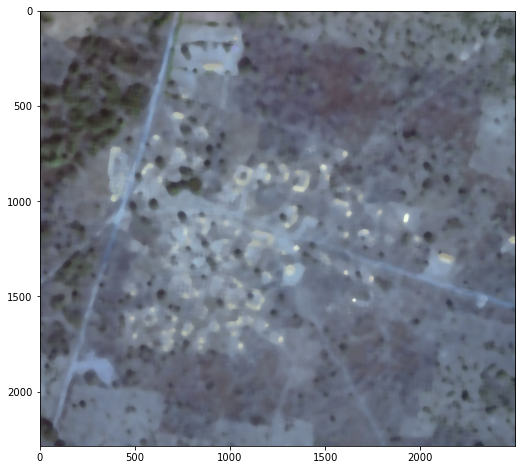

In [156]:
display(img)

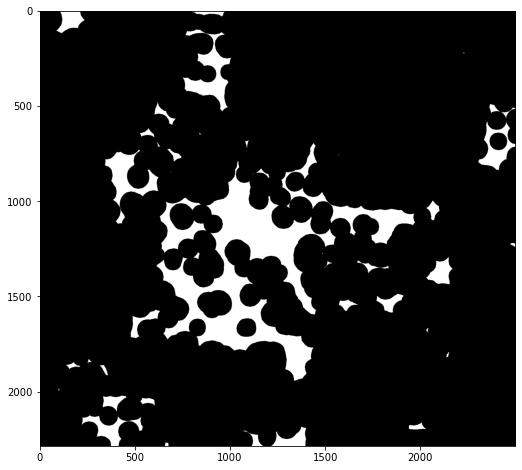

In [157]:
display(sure_fg,cmap='gray')

#### Step 8: Find Unknown Region

In [158]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

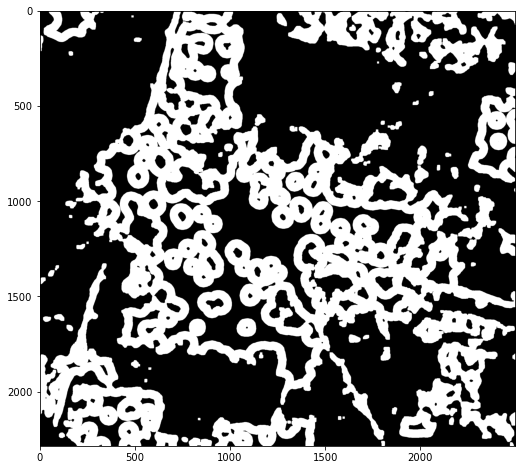

In [159]:
display(unknown,cmap='gray')

#### Step 9: Label Markers of Sure Foreground

In [160]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

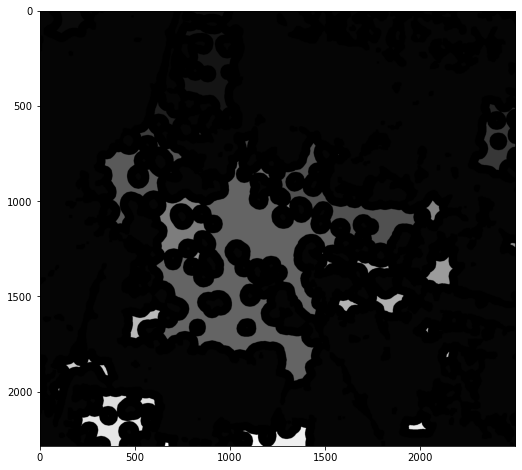

In [161]:
display(markers,cmap='gray')

#### Step 10: Apply Watershed Algorithm to find Markers

In [162]:
markers = cv2.watershed(img,markers)

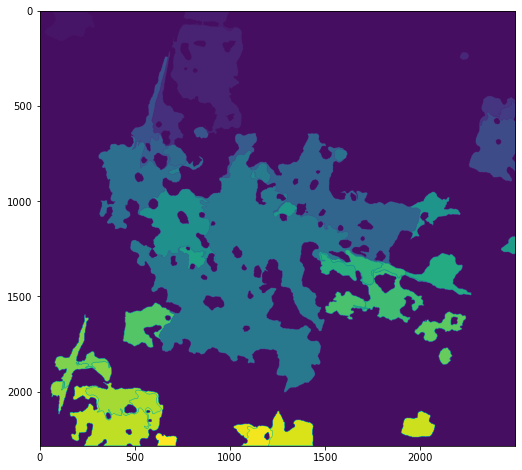

In [163]:
display(markers)

#### Step 11: Find Contours on Markers

In [164]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(img, contours, i, (255, 0, 0), 10)

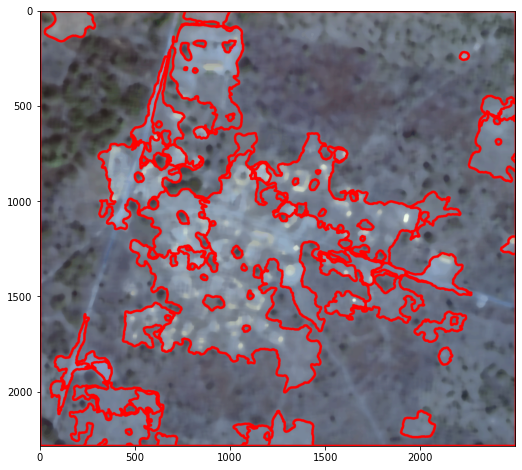

In [165]:
display(img)

In [200]:
img = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

In [201]:
def get_house_pixels(x):
    vill = x['village']
    house = x['houses']
    
    image = imreads[vill]
    pts = np.array(house)

    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = image[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)

    ## (4) add the white background
    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst

    house_pixels = dst2.reshape(dst2.shape[0]*dst2.shape[1],dst2.shape[2])
    house_pixels_nw = [pix for pix in house_pixels if (pix != [255,255,255]).all()]
    
    return house_pixels_nw

In [202]:
df['house_pixels_nw'] = df.apply(lambda x: get_house_pixels(x), axis=1)

In [203]:
df_metal = df[df['type']=='metal']

In [204]:
metal_dict = df_metal.T.to_dict()
all_pixels = []
l_village = []
l_house_n = []
for i in metal_dict:
    row = metal_dict[i]
    pixels = row['house_pixels_nw']
    all_pixels= all_pixels+pixels
    l_village = l_village+[row['village'] for p in pixels]
    l_house_n = l_house_n+[i for p in pixels]

In [238]:
l_nhp = []
for v in df['village'].unique():
    image = cv2.imread('/Users/daniel/OAN/SID/poc/'+v+'_5_19_500.png')
    for house in df[df['village']==vill]['houses'].to_list():
        pts = np.array(house)

        ## (1) Crop the bounding rect
        rect = cv2.boundingRect(pts)
        x,y,w,h = rect
        image[y:y+h, x:x+w] = 0
    not_house_pixels = image.reshape(image.shape[0]*image.shape[1],image.shape[2])
    not_house_pixels_nw = [pix for pix in not_house_pixels if (pix != [0,0,0]).all()]
    l_nhp =l_nhp + not_house_pixels_nw

In [239]:
set_nh = set([tuple(a) for a in l_nhp])

In [248]:
len(all_pixels)

289485

In [240]:
house_pix = list([a for a in all_pixels if tuple(a) not in set_nh])

In [247]:
len(house_pix)

31879

In [249]:
df_pixels = pd.DataFrame({'all_pix':house_pix})

In [250]:
df_pixels['red'] = df_pixels['all_pix'].apply(lambda x: x[0])
df_pixels['green'] = df_pixels['all_pix'].apply(lambda x: x[1])
df_pixels['blue'] = df_pixels['all_pix'].apply(lambda x: x[2])

In [256]:
most_pix = df_pixels['all_pix'].apply(tuple).value_counts().reset_index()

In [257]:
most_pix.columns = ['pixel','count']

In [258]:
most_pix

pixel  count
0   (188, 196, 188)   4475
1   (203, 211, 195)   1704
2   (198, 203, 198)   1299
3   (207, 219, 203)    984
4   (199, 203, 195)    978
..              ...    ...
58        (0, 4, 3)      6
59        (8, 0, 4)      3
60        (8, 0, 8)      3
61      (16, 20, 0)      1
62        (3, 0, 0)      1

[63 rows x 2 columns]

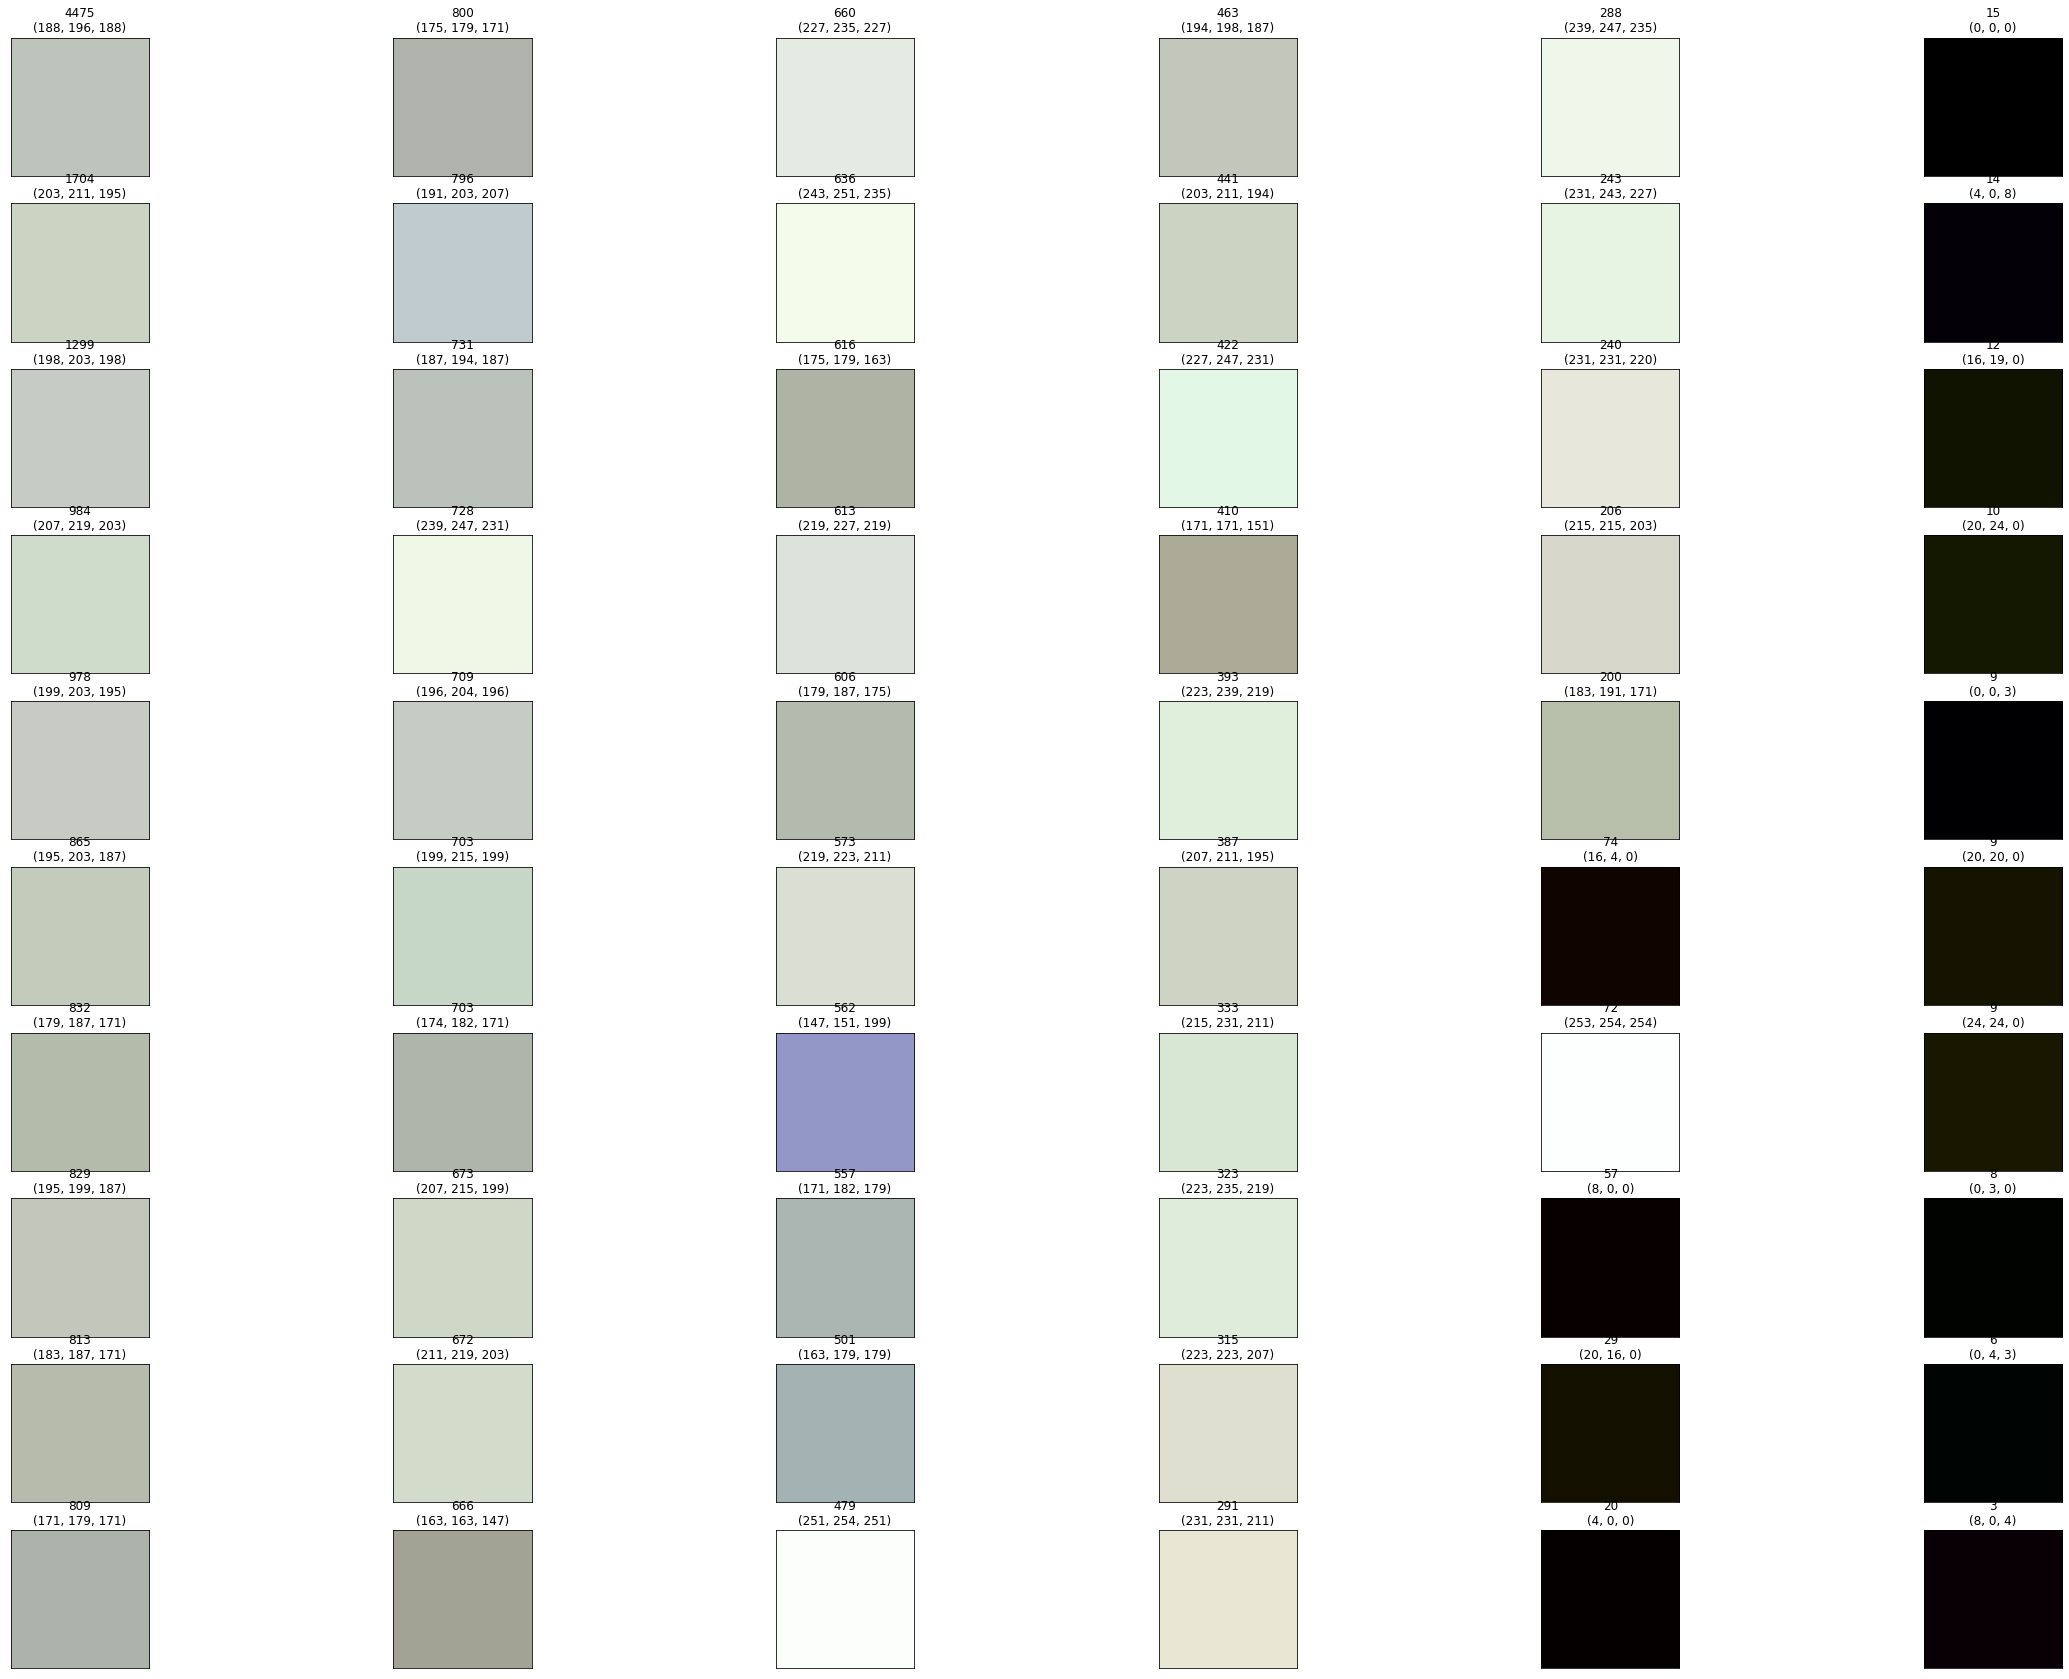

In [261]:
f, ax = plt.subplots(10,6,figsize=(40,30))
mmdict = most_pix.iloc[0:60].T.to_dict()
for rr,k in enumerate(mmdict):
    row = mmdict[k]
    piixel = row['pixel']
    pix_im = np.ones(shape=(4,4,3))
    im_pix = np.where(pix_im==[1,1,1],piixel,[0,0,0])
    axx = ax[rr%10,int(rr/10)]
    axx.imshow(im_pix)
    axx.set_title(str(row['count'])+'\n'+str(row['pixel']))
    axx.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
plt.show()

In [262]:
im_monnon = imreads['Monnon'].copy()

In [280]:
best_pix =  most_pix['pixel'][0:60]

In [281]:
im_monnon_mask = [imreads['Monnon'].copy() for a in best_pix]

In [282]:
tbest_pix = tqdm(best_pix)
start_time = time.time()
for b,bp in enumerate(tbest_pix):
    im_monnon_copy = im_monnon.copy()
    im_monnon_copy[np.all(im_monnon_copy == bp, axis=-1)] = [255,0,0]
    im_monnon_copy[np.logical_not(np.all(im_monnon_copy == [255,0,0], axis=-1))] = [0,0,0]
    im_monnon_mask[b] = im_monnon_copy
end_time = time.time()
print('took: {}'.format(end_time-start_time))

100%|██████████| 60/60 [00:28<00:00,  2.12it/s]

took: 28.351539850234985


In [283]:
im_monnon_mask_sum = np.zeros(shape = im_monnon.shape)
for i,elem in enumerate(im_monnon_mask):
    im_monnon_mask_sum = np.add(im_monnon_mask_sum,elem)

In [284]:
im_monnon_mask_sum=np.array(im_monnon_mask_sum,dtype='int32')

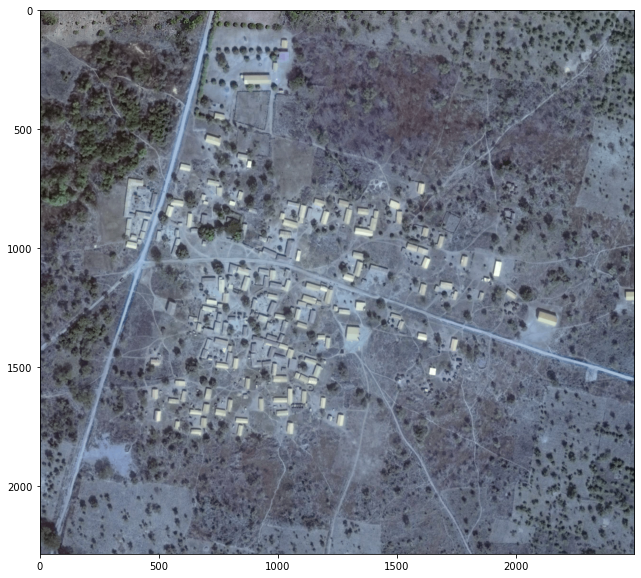

In [285]:
plt.figure(figsize=(20,10))
plt.imshow(im_monnon)

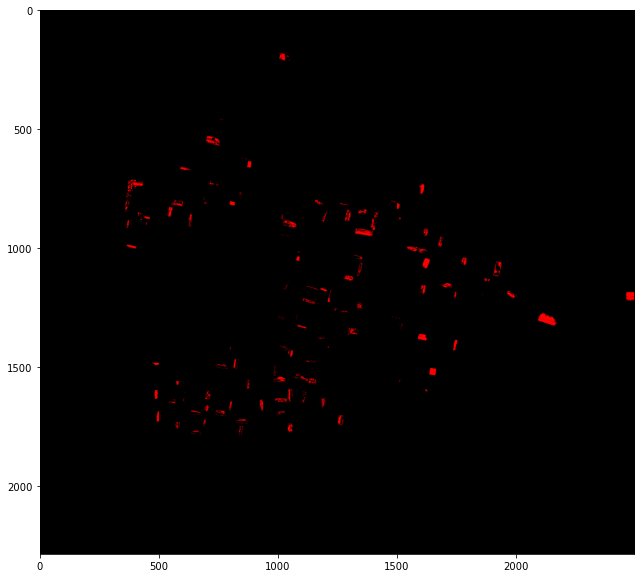

In [295]:
plt.figure(figsize=(20,10))
plt.imshow(im_monnon_mask_sum)

In [301]:
gray_image = cv2.cvtColor(im_monnon_mask_sum.astype(np.uint8),cv2.COLOR_RGB2GRAY)

In [317]:
ret, sep_thresh = cv2.threshold(gray_image,50,255,cv2.THRESH_BINARY)

In [349]:
img = im_monnon.copy()

#### Step 6: Grab Background that you are sure of

In [384]:
# sure background area
sure_bg = cv2.dilate(sep_thresh,kernel,iterations=3)

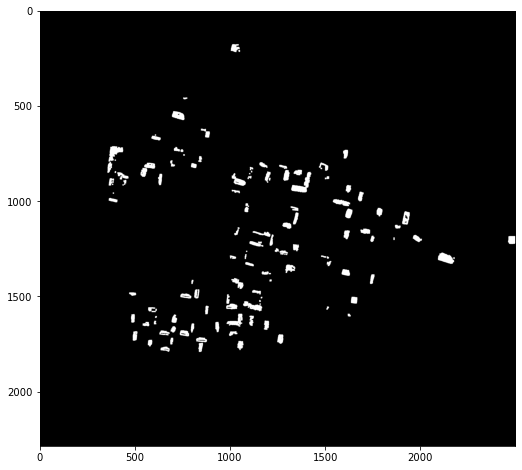

In [385]:
display(sure_bg,cmap='gray')

#### Step 7: Find Sure Foreground

In [386]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)

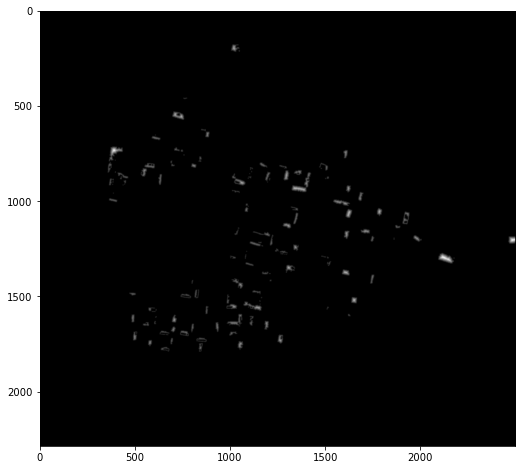

In [387]:
display(dist_transform,cmap='gray')

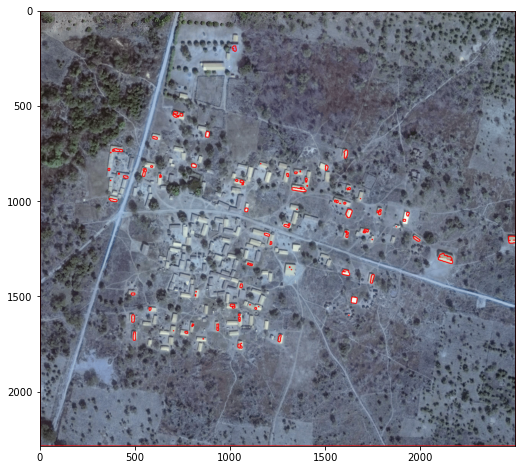

In [388]:
display(img)

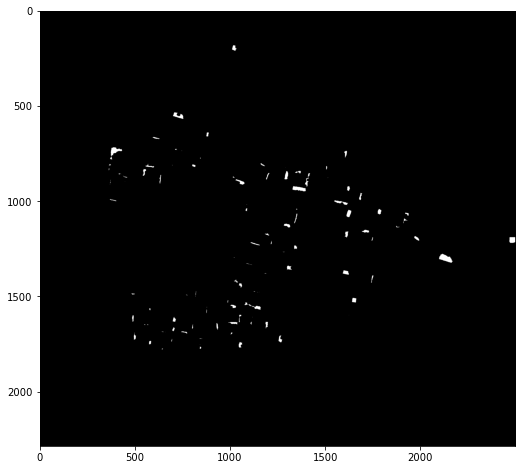

In [389]:
display(sure_fg,cmap='gray')

#### Step 8: Find Unknown Region

In [390]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

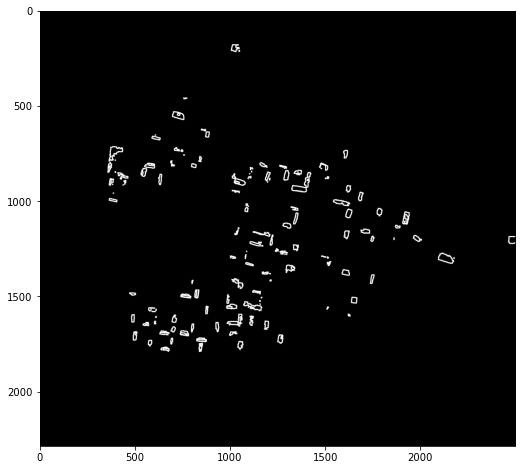

In [391]:
display(unknown,cmap='gray')

#### Step 9: Label Markers of Sure Foreground

In [392]:
# Marker labelling

ret, markers = cv2.connectedComponents(opening)
## Add one to all labels so that sure background is not 0, but 1
markers = markers+1
## Now, mark the region of unknown with zero
markers[unknown==255] = 0

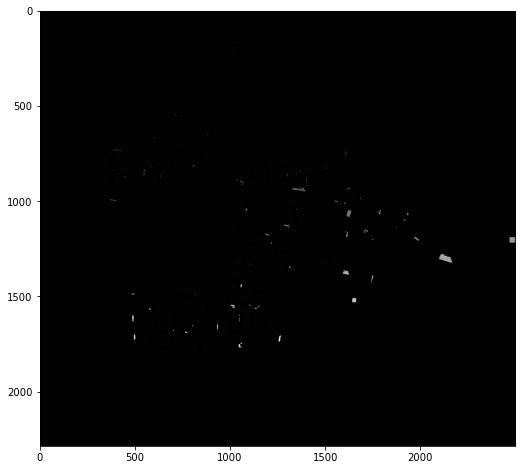

In [393]:
display(markers,cmap='gray')

#### Step 10: Apply Watershed Algorithm to find Markers

In [394]:
markers = cv2.watershed(img,markers)

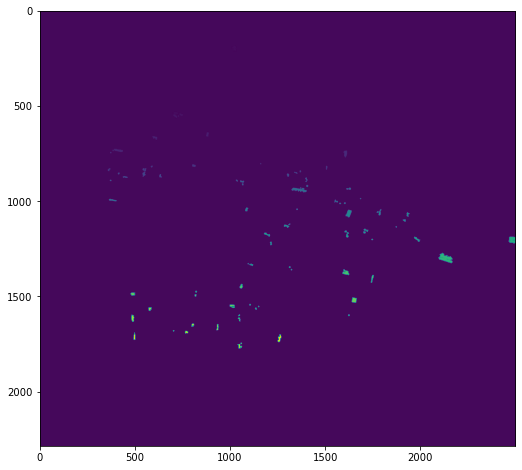

In [395]:
display(markers)

#### Step 11: Find Contours on Markers

In [396]:
img = im_monnon.copy()
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(img, contours, i, (255, 0, 0), 2)

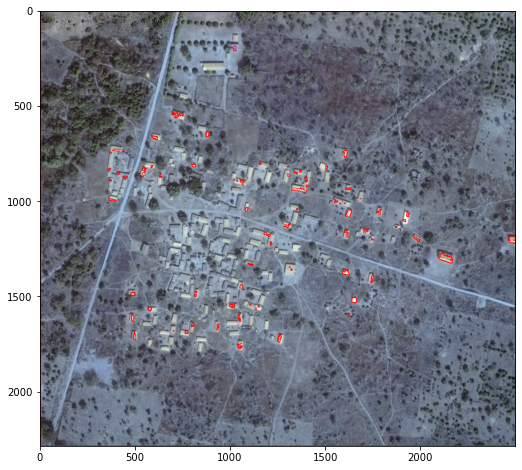

In [397]:
display(img)